<a href="https://colab.research.google.com/github/effieklestz/Chesapeake/blob/main/Q1_ML_Monthly_previous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

username = 'Ephraim.klestzick@rossilabs.com'
password = 'Rj2^1!OJ@F%Q1CWs7!nA'
server_name = 'https://chesapeake.sisense.com/'

login_data =    {  'username' : username,
                        'password' : password
                    }

login_url = server_name + '/api/v1/authentication/login'
login_res = requests.post(url=login_url, data=login_data).json()

access_token = login_res.get('access_token')
if len(access_token) > 0:
    print('login succesful.')

api_header = {'Authorization': 'Bearer ' + access_token}

url = server_name + '/api/v1/users?'

urlSQL = server_name + '/api/datasources/ML_Project/sql?count=-1&includeMetadata=true&query=select%20%2A%20from%20ML_Features'

response = requests.get(urlSQL, headers=api_header)
if response.status_code == 404:
    print("Error: API endpoint not found.")

response_data = json.loads(response.text)


login succesful.


Functions

In [2]:
# Functions
def min_max_scale(dataframe, target_column):
    mm = MinMaxScaler()
    features = dataframe.drop(columns=[target_column])
    scaled_features = mm.fit_transform(features)
    scaled_dataframe = pd.DataFrame(scaled_features, columns=features.columns)
    scaled_dataframe[target_column] = dataframe[target_column]
    return scaled_dataframe


def split_data(series, train_fraq, test_len=6):

    test_slice = len(series)-test_len

    test_data = series[test_slice:]
    train_val_data = series[:test_slice]
    train_size = int(len(train_val_data) * train_fraq)

    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]

    return train_data, val_data, test_data

def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
      for y_curr in y:
        plt.plot(x[start:end], y_curr[start:end], format)
    else:
      plt.plot(x[start:end], y[start:end], format)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
      plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_predictions2(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    y_actual = np.concatenate([batch_y.numpy() for _, batch_y in test_ds])
    df = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y_actual})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y_actual, predictions)

def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):

    window = n_steps

    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)

    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda x : (x[:, :-1], x[:, -1:]))
    ds = ds.batch(batch_size).prefetch(1)

    return ds

def df_to_X1_y1(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][-1]
    y.append(label)
  return np.array(X), np.array(y)

def plot_comparison(df, target_column, comparison_column ):

    plt.figure(figsize=(5, 3))
    plt.plot(df[target_column], color='blue', label=target_column)
    plt.ylabel(target_column)

    plt.twinx()
    plt.plot(df[comparison_column], color='red', label=comparison_column)
    plt.ylabel(comparison_column)
    plt.legend(loc='upper left')

    plt.show()

In [3]:
import pandas as pd
headers = response_data['headers']
values = response_data['values']

df = pd.DataFrame(values, columns=headers)

# df.head()

Exploratory Data Analysis

In [ ]:
# for column in df.columns:
#   plot_comparison(df, 'TargetRev', column)

Preprocess

In [4]:
df.drop(['TotalRevenue'], axis=1,inplace=True)
df.drop(['CommercialJobsEnded'], axis=1,inplace=True)
df.drop(['CommercialJobsStarted'], axis=1,inplace=True)
df.drop(['VolumeHousingSWRevenuePct'], axis=1,inplace=True)
df.drop(['SchellUnderslabRevenuePct'], axis=1,inplace=True)
df.drop(['InsightUnderslabRevenuePct'], axis=1,inplace=True)
df.drop(['Month2'], axis=1,inplace=True)
df.drop(['Month1'], axis=1,inplace=True)
df.drop(['Month'], axis=1,inplace=True)

Define Function Variables


In [5]:
n_steps = 6
n_horizon = 2
batch_size = 1
shuffle_buffer = 5
expand_dims=False

Scale and Split Data - Print for testing


In [44]:
# Scale and Split funtions
scaled_df = min_max_scale(df, 'TargetRev')
train_multi, val_multi, test_multi = split_data(scaled_df, train_fraq=0.65, test_len=6)

train_multi.astype("float32")
print("Multivarate Datasets")
print(f"Train Data Shape: {train_multi.shape}")
print(f"Val Data Shape: {val_multi.shape}")
print(f"Test Data Shape: {test_multi.shape}")
print(f"Nulls In Train {np.any(np.isnan(train_multi))}")
print(f"Nulls In Validation {np.any(np.isnan(val_multi))}")
print(f"Nulls In Test {np.any(np.isnan(test_multi))}")


Multivarate Datasets
Train Data Shape: (29, 85)
Val Data Shape: (16, 85)
Test Data Shape: (6, 85)
Nulls In Train False
Nulls In Validation False
Nulls In Test False


In [45]:
n_steps = 6
n_horizon = 2
batch_size = 1
shuffle_buffer = 5
expand_dims=False



def window_datasets(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):

    window = n_steps



    ds = tf.expand_dims(data, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(ds)


    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)
    # ds = ds.map(lambda x: (x[:, :-1], tf.reshape(x[:, -1:], (-1, 2))))
    ds = ds.map(lambda x : (x[:, :-1], x[-n_horizon:, -1:]))
    # ds = ds.map(lambda x: (x[:, :-1], tf.reshape(x[:, -n_horizon:], (-1, 1))))  # Adjust target labels

    # ds = ds.map(lambda x: (x[:, :-n_horizon], x[:, -n_horizon:])) <-- changes the number of targets from 1 to 2
    # ds = ds.map(lambda x : (x[:, :], x[:, -1:]))
    ds = ds.batch(batch_size).prefetch(1)

    return ds

train_ds = window_datasets(train_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True,expand_dims=expand_dims)
val_ds = window_datasets(val_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True, expand_dims=expand_dims)
test_ds = window_datasets(test_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True,expand_dims=expand_dims )

print('Example sample shapes')
for idx,(x,y) in enumerate(test_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break
print(test_ds)
for idx,(x,y) in enumerate(test_ds):

    print("y = ", y)
    print("y = ", x)
    break

Example sample shapes
x =  (1, 6, 84)
y =  (1, 2, 1)
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 84), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
y =  tf.Tensor(
[[[4452374.18]
  [4738175.53]]], shape=(1, 2, 1), dtype=float64)
y =  tf.Tensor(
[[[0.37777778 0.54782609 0.69577586 0.         0.58644003 0.08915721
   0.43780871 0.03596877 0.53731343 0.05262253 0.08601539 0.00654354
   0.86280694 0.         0.13719156 0.26226763 0.41988055 0.48703583
   0.18612779 0.07698294 0.67558684 0.48209256 0.79929594 0.04077466
   0.27881892 0.62984601 0.25391307 0.89856941 0.31128106 0.76089196
   0.72819793 0.06928161 0.4065494  0.02355611 0.77505024 0.1347832
   0.40075135 0.20060848 0.77438916 0.55882642 0.34649181 0.338427
   0.61418499 0.63817978 0.07581919 0.         0.22627193 0.74342661
   0.4501991  0.17712409 0.3858038  0.27893035 0.18721142 0.47453083
   0.03636364 0.07293666 0.28865979 0.49712644 0.04347826 0.73602484
 

In [14]:
train_ds = window_dataset(train_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True,expand_dims=expand_dims)
val_ds = window_dataset(val_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True, expand_dims=expand_dims)
test_ds = window_dataset(test_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True,expand_dims=expand_dims )



print('Example sample shapes')
for idx,(x,y) in enumerate(test_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break
print(test_ds)
for idx,(x,y) in enumerate(test_ds):

    print("y = ", y)
    break

Example sample shapes
x =  (1, 6, 84)
y =  (1, 6, 1)
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 84), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
y =  tf.Tensor(
[[[4441649.36]
  [3989358.05]
  [4497625.1 ]
  [3750360.13]
  [3721166.95]
  [3805989.64]]], shape=(1, 6, 1), dtype=float64)


In [54]:
def get_params(multivar=False):
    lr = 0.45
    n_steps=6
    n_horizon=2
    n_features=84


    return n_steps, n_horizon, n_features, lr

model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):

    n_steps, n_horizon, n_features, lr = get_params(multivar=True)


    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

In [55]:
def lstm_model(n_steps, n_horizon, n_features, lr):

    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=(n_steps, n_features),kernel_regularizer=tf.keras.regularizers.l2(0.1)),


        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True,kernel_regularizer=tf.keras.regularizers.l2(0.1))),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=False ,kernel_regularizer=tf.keras.regularizers.l2(0.1))),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')

    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)

    model.compile(loss=loss, optimizer='adam', metrics=['mae'],run_eagerly=True)

    return model



lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             16192     
                                                                 
 bidirectional (Bidirection  (None, 6, 128)            66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320   

Epoch 1/20
12/12 [==============================] - 3s 259ms/step - loss: 4634745.0000 - mae: 4634698.5000 - val_loss: 4248531.0000 - val_mae: 4248491.0000
Epoch 2/20
12/12 [==============================] - 4s 322ms/step - loss: 4634733.5000 - mae: 4634698.0000 - val_loss: 4248521.0000 - val_mae: 4248490.5000
Epoch 3/20
12/12 [==============================] - 3s 254ms/step - loss: 4634716.0000 - mae: 4634689.0000 - val_loss: 4248459.5000 - val_mae: 4248435.5000
Epoch 4/20
12/12 [==============================] - 3s 253ms/step - loss: 4632828.5000 - mae: 4632806.5000 - val_loss: 4241264.5000 - val_mae: 4241244.5000
Epoch 5/20
12/12 [==============================] - 4s 292ms/step - loss: 4574990.5000 - mae: 4574971.0000 - val_loss: 3971113.2500 - val_mae: 3971093.2500
Epoch 6/20
12/12 [==============================] - 3s 256ms/step - loss: 2718288.7500 - mae: 2718268.2500 - val_loss: 1158695.5000 - val_mae: 1158674.1250
Epoch 7/20
12/12 [==============================] - 3s 258ms/ste

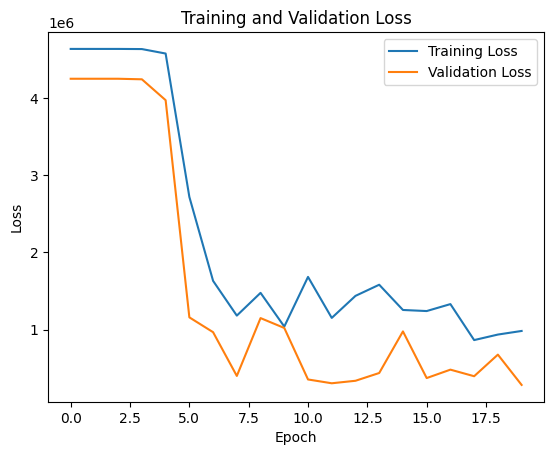

In [56]:
tf.keras.backend.clear_session()
history = lstm.fit(train_ds, validation_data=(val_ds), epochs=20)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [57]:
predictions = lstm.predict(test_ds).flatten()
train_results = pd.DataFrame(data={'Predictions':predictions})
train_results

1/1 [==============================] - 0s 115ms/step


,Predictions
0,3946756.00
1,4001039.75
